In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

<font size="3" color='blue'>    <b>Offset correction for EMG -> +0.28 on Biceps</b>

In [5]:
pID = '4'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 1s
data_eeg_name_1 = '\data_s4_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s4_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s4_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

In [6]:
data_eeg

,sample,epoch_ix,rp_class,P2,Oz,P4,POz,FC5,VEOG,CP5,...,P8,O2,PO4,PO8,P1,Pz,FC3,C1,C3,CP3
0,-0.996,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.992,1,1,1.933655,0.133655,1.533653,-0.066347,-1.266346,-1.400000,1.033655,...,0.833655,3.433651,1.133659,1.533653,2.133654,1.433655,-0.766346,1.633650,0.333654,2.233654
2,-0.988,1,1,-0.485260,-0.985265,0.614738,-4.985264,-0.685265,-1.500000,-4.385263,...,-2.585263,-1.785267,-0.685265,-0.585264,2.614737,-0.785267,3.114737,5.914732,2.414736,3.414736
3,-0.984,1,1,-3.147911,-2.247908,-0.147911,-5.447906,0.852095,-7.699999,-1.247904,...,-3.947905,-7.447906,-4.547901,-2.247906,3.452093,0.252094,5.252094,9.952093,6.852095,4.552094
4,-0.980,1,1,-5.406136,-3.806142,-0.906143,-7.106142,-3.406141,-3.999999,1.793861,...,-8.106140,-5.106144,-7.506142,-4.706142,2.593857,-1.606144,3.093859,7.093855,7.793859,4.193859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,-0.016,304,2,-0.122493,11.077509,5.477509,-3.422492,-14.922489,52.199997,-7.622490,...,5.177509,-4.922492,6.077508,4.777508,-2.022492,-3.222489,-10.722493,3.277507,19.777509,0.777507
75996,-0.012,304,2,-1.793477,7.206524,3.706524,-7.693476,-11.293476,49.599998,-6.793478,...,2.806524,-8.393477,0.806524,-0.793478,-1.693478,-5.893475,-10.093478,4.906523,20.806522,1.406522
75997,-0.008,304,2,-1.064932,5.635070,5.735069,-8.264931,-16.264931,52.999996,-11.064930,...,4.835070,-3.764932,2.035069,-1.864929,-2.464931,-4.664930,-12.464932,2.935068,18.735069,1.335068
75998,-0.004,304,2,3.231095,7.131098,9.031097,-4.668903,-21.368904,53.799995,-11.568901,...,7.331098,-1.968904,3.631097,1.131096,-0.268904,-2.568902,-13.968905,1.631095,17.631097,2.631095


In [7]:
#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [8]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)


<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [11]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.7175268817204301
0.05303604709623829


<font size="3">    <b>Classification metrics - EMG</b>

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3" color='red'>    <b>Load the data and keep 20 best EEG</b>

In [12]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/4/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/4/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/4/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/4/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None) # , dtype='float16'
velocity = pd.read_csv(pathm, header=None) # , dtype='float16'

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

<font size="3" color='red'>    <b>Extract the time frame of interest around the movement onset</b>

In [13]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='red'>    <b>Baseline correction: I think this messes up the final result</b>

In [14]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3" color='red'>    <b>EEG Feature extraction</b>

In [15]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+10*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

In [16]:
feat.shape

(178, 200, 2751)

<font size="3" color='red'>    <b>Probability extraction</b>

In [17]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>Final DataFrame and representation</b>

In [18]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity * 1000
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.122760,0.993163
1,-1.999,0.125185,0.993703
2,-1.998,0.127291,0.993465
3,-1.997,0.128936,0.993013
4,-1.996,0.129975,0.991822
...,...,...,...
489673,0.746,0.015537,0.911570
489674,0.747,0.015919,0.917806
489675,0.748,0.016351,0.921455
489676,0.749,0.016591,0.922231


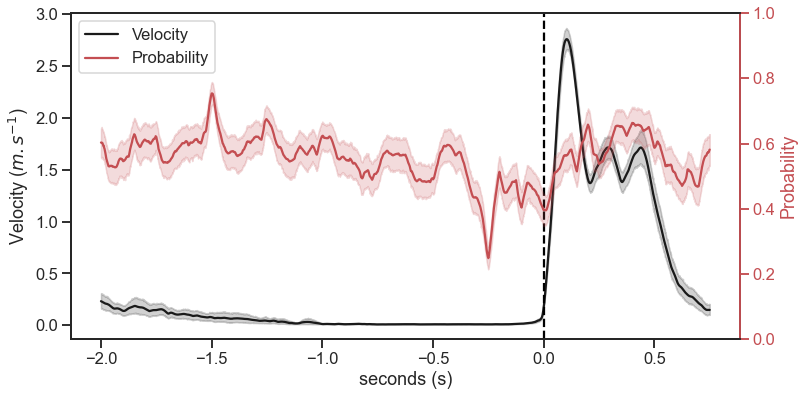

In [21]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))
# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

In [20]:
final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())]

-0.25